In [1]:
cd ..

/home/yann/IVISpaces


In [2]:
from Data import get_setup
import os
from datetime import datetime
import timeit

import torch.nn.functional as F
import torch
from torch import nn
from torch.utils.data import Dataset
from tqdm import trange
from Data import get_setup
from Inference_new import *
from Models.VI import *
from Tools import uniform_rect_sampler
import argparse


In [3]:
device =torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')


In [4]:
## large ##
# predictive model architecture
layerwidth = 100
nblayers = 1
activation = nn.ReLU()



In [5]:
path="Results/Paper/Exp1/Exp1_large"

In [6]:
MODELS=torch.load(path+"2021-02-03-14:47powerplant_models.pt",map_location=device)
#MODELS['navalC']=torch.load(path+"2021-02-03-21:52navalC_models.pt",map_location=device)['navalC'] #sigma=0.05
#MODELS['navalC']=torch.load(path+"2021-02-04-00:51navalC_models.pt",map_location=device)['navalC'] #sigma=0.1
MODELS['navalC']=torch.load(path+"2021-02-04-08:34navalC_models.pt",map_location=device)['navalC'] #sigma=0.2
#MODELS['navalC']=torch.load(path+"2021-02-04-11:39navalC_models.pt",map_location=device)['navalC'] #sigma=0.2 lat_dim=10
MODELS['protein']=torch.load(path+"2021-02-03-15:48protein_models.pt",map_location=device)['protein']



#models_HMC = torch.load('Results/HMC_models.pt')


In [7]:
import pandas as pd
for key, value in MODELS.items():
    print(key+"{}".format(len(value)))

navalC3
powerplant3
protein3


In [8]:
#torch.cat([model(x_, 1000).detach() for x_ in x.split(500,dim=0)],dim=0)
for dataset in ['navalC']:   

    for split in MODELS[dataset]:
        split_results={}
        x_train, y_train=split[0]['train']
        x_test, y_test=split[0]['test']
        input_dim=x_test.shape[1]
        std_y_train=split[0]['scaler_y']

  
        method="FuNN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        print(model.sigma_noise)
    
        

tensor(0.2000, device='cuda:1', grad_fn=<LogBackward>)
tensor(0.2000, device='cuda:1', grad_fn=<LogBackward>)
tensor(0.2000, device='cuda:1', grad_fn=<LogBackward>)


In [9]:
datasets = ['navalC', 'powerplant', 'protein']# for key in MODELS.keys():
#     datasets.append(key)

methods=['MC dropout','Ensemble','MFVI', 'FuNN-MFVI', 'NN-HyVI', 'FuNN-HyVI']#[ 'MC dropout','Ensemble']
# for key in MODELS['energy'][0][1].keys():
#     methods.append(key)
    
datasets, methods

(['navalC', 'powerplant', 'protein'],
 ['MC dropout', 'Ensemble', 'MFVI', 'FuNN-MFVI', 'NN-HyVI', 'FuNN-HyVI'])

In [10]:
from Metrics import rmse, lpp, lpp_gaussian
def get_metrics(y_pred, sigma_noise, y_test, std_y_train, time, gaussian_prediction=False):
    metrics = {}
    rmse_test, _ = rmse(y_pred.mean(dim=0).cpu(), y_test.cpu(), std_y_train.cpu())
    metrics.update({'RMSE': rmse_test})

    if gaussian_prediction:
        lpp_test, _ = lpp_gaussian(y_pred.cpu(), y_test.cpu(), sigma_noise.cpu(), std_y_train.cpu())
    else:
        lpp_test, _ = lpp(y_pred.cpu(), y_test.cpu(), sigma_noise.view(1, 1, 1).cpu(), std_y_train.cpu())

    metrics.update({'LPP': lpp_test})
    metrics.update({'time [s]': time})
    metrics.update({'std noise': sigma_noise.item()})
    return metrics

In [11]:
results=[]

for dataset in datasets:   

    for split in MODELS[dataset]:
        split_results={}
        x_train, y_train=split[0]['train']
        x_test, y_test=split[0]['test']
        input_dim=x_test.shape[1]
        std_y_train=split[0]['scaler_y']



        method="MC dropout"
        model = MC_Dropout(input_dim, 1, layerwidth, init_sigma_noise=1., drop_prob=0.05, learn_noise=True,
                               activation=activation).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model.predict(x_test, 1000)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2], gaussian_prediction=True)
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        sigma_noise=model.sigma_noise
        method="Ensemble"
        model = ensemble(input_dim, layerwidth, activation, num_models=5).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model(x_test)
        metrics = get_metrics(y_pred, sigma_noise, y_test, std_y_train, split[1][method][2], gaussian_prediction=True)
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        
        method="MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=torch.cat([model(x_, 1000).detach() for x_ in x_test.split(100,dim=0)],dim=1)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        method="NN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=torch.cat([model(x_, 1000).detach() for x_ in x_test.split(100,dim=0)],dim=1)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        method="FuNN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=torch.cat([model(x_, 1000).detach() for x_ in x_test.split(100,dim=0)],dim=1)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        method="FuNN-MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=torch.cat([model(x_, 1000).detach() for x_ in x_test.split(100,dim=0)],dim=1)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
#         sigma_noise=model.sigma_noise
#         predictor=model.predictor
#         method='HMC'
#         HMC_=models_HMC[dataset]
#         indices = torch.randperm(len(HMC_))[:1000]
#         theta=HMC_[indices].to(device)
#         y_pred=predictor(x_test,theta)
#         metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train,'NA')
#         metrics.update({'dataset':dataset,'method':method})
#         results.append(metrics)
        
        #Results.append({dataset:split_results})

In [12]:
#torch.save(results,path+'_results.pt')
results=torch.load(path+'_results.pt')

# RMSE

In [13]:
import pandas as pd

df=pd.DataFrame(results).loc[:,['dataset','method','RMSE']].groupby(['dataset','method']).mean()#.transpose()
df_sem=pd.DataFrame(results).loc[:,['dataset','method','RMSE']].groupby(['dataset','method']).sem()

def collapse_columns(df):
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.to_series().apply(lambda x: x[1])
    return df

df_=collapse_columns(df.unstack()).reindex(columns=methods)
df_sem_=collapse_columns(df_sem.unstack()).reindex(columns=methods)
df_.style.background_gradient(axis=1,cmap='viridis_r')
df_.style.highlight_min(axis=1)


,MC dropout,Ensemble,MFVI,FuNN-MFVI,NN-HyVI,FuNN-HyVI
dataset,,,,,,
navalC,0.000381,0.000410,0.000503,0.000947,0.000246,0.000247
powerplant,3.693671,3.697553,4.049132,4.178826,3.872143,3.713612
protein,4.383509,4.168499,4.884762,4.489408,4.519500,4.258814


In [14]:
for i in df_.columns:
    df_[i] = df_[i].round(5).astype(str)+ "±" + (df_sem_[i].round(5)).astype(str)+""

In [15]:
print(df_.to_latex())

\begin{tabular}{lllllll}
\toprule
{} &       MC dropout &         Ensemble &             MFVI &        FuNN-MFVI &          NN-HyVI &        FuNN-HyVI \\
dataset    &                  &                  &                  &                  &                  &                  \\
\midrule
navalC     &    0.00038±1e-05 &    0.00041±2e-05 &     0.0005±5e-05 &  0.00095±0.00017 &    0.00025±3e-05 &    0.00025±3e-05 \\
powerplant &  3.69367±0.01355 &  3.69755±0.00337 &  4.04913±0.02809 &   4.17883±0.0754 &  3.87214±0.01769 &  3.71361±0.01161 \\
protein    &  4.38351±0.00086 &   4.1685±0.01109 &  4.88476±0.00709 &  4.48941±0.06054 &   4.5195±0.01208 &  4.25881±0.01487 \\
\bottomrule
\end{tabular}



# LPP

In [16]:
import pandas as pd

df=pd.DataFrame(results).loc[:,['dataset','method','LPP']].groupby(['dataset','method']).mean()#.transpose()
df_sem=pd.DataFrame(results).loc[:,['dataset','method','LPP']].groupby(['dataset','method']).sem()

def collapse_columns(df):
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.to_series().apply(lambda x: x[1])
    return df

df_=collapse_columns(df.unstack()).reindex(columns=methods)
df_sem_=collapse_columns(df_sem.unstack()).reindex(columns=methods)
df_.style.background_gradient(axis=1,cmap='viridis')
df_.round(2).style.highlight_max(axis=1)


,MC dropout,Ensemble,MFVI,FuNN-MFVI,NN-HyVI,FuNN-HyVI
dataset,,,,,,
navalC,6.070000,6.260000,-8.270000,-42.460000,4.710000,4.240000
powerplant,-4.890000,-60.640000,-4.890000,-4.890000,-4.890000,-4.890000
protein,-4.230000,-16.720000,-4.230000,-4.230000,-4.230000,-4.220000


In [17]:
for i in df_.columns:
    df_[i] = df_[i].round(2).astype(str)+ "±" + (df_sem_[i].round(5)).astype(str)+""

In [18]:
print(df_.to_latex())

\begin{tabular}{lllllll}
\toprule
{} &    MC dropout &         Ensemble &          MFVI &        FuNN-MFVI &       NN-HyVI &     FuNN-HyVI \\
dataset    &               &                  &               &                  &               &               \\
\midrule
navalC     &  6.07±0.02685 &     6.26±0.01591 &  -8.27±3.0823 &  -42.46±16.27946 &  4.71±0.72598 &  4.24±1.16301 \\
powerplant &   -4.89±1e-05 &  -60.64±10.19581 &   -4.89±4e-05 &    -4.89±0.00035 &   -4.89±2e-05 &   -4.89±2e-05 \\
protein    &   -4.23±1e-05 &   -16.72±0.81962 &   -4.23±6e-05 &    -4.23±0.00074 &  -4.23±0.0001 &   -4.22±9e-05 \\
\bottomrule
\end{tabular}



# displaying logs

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

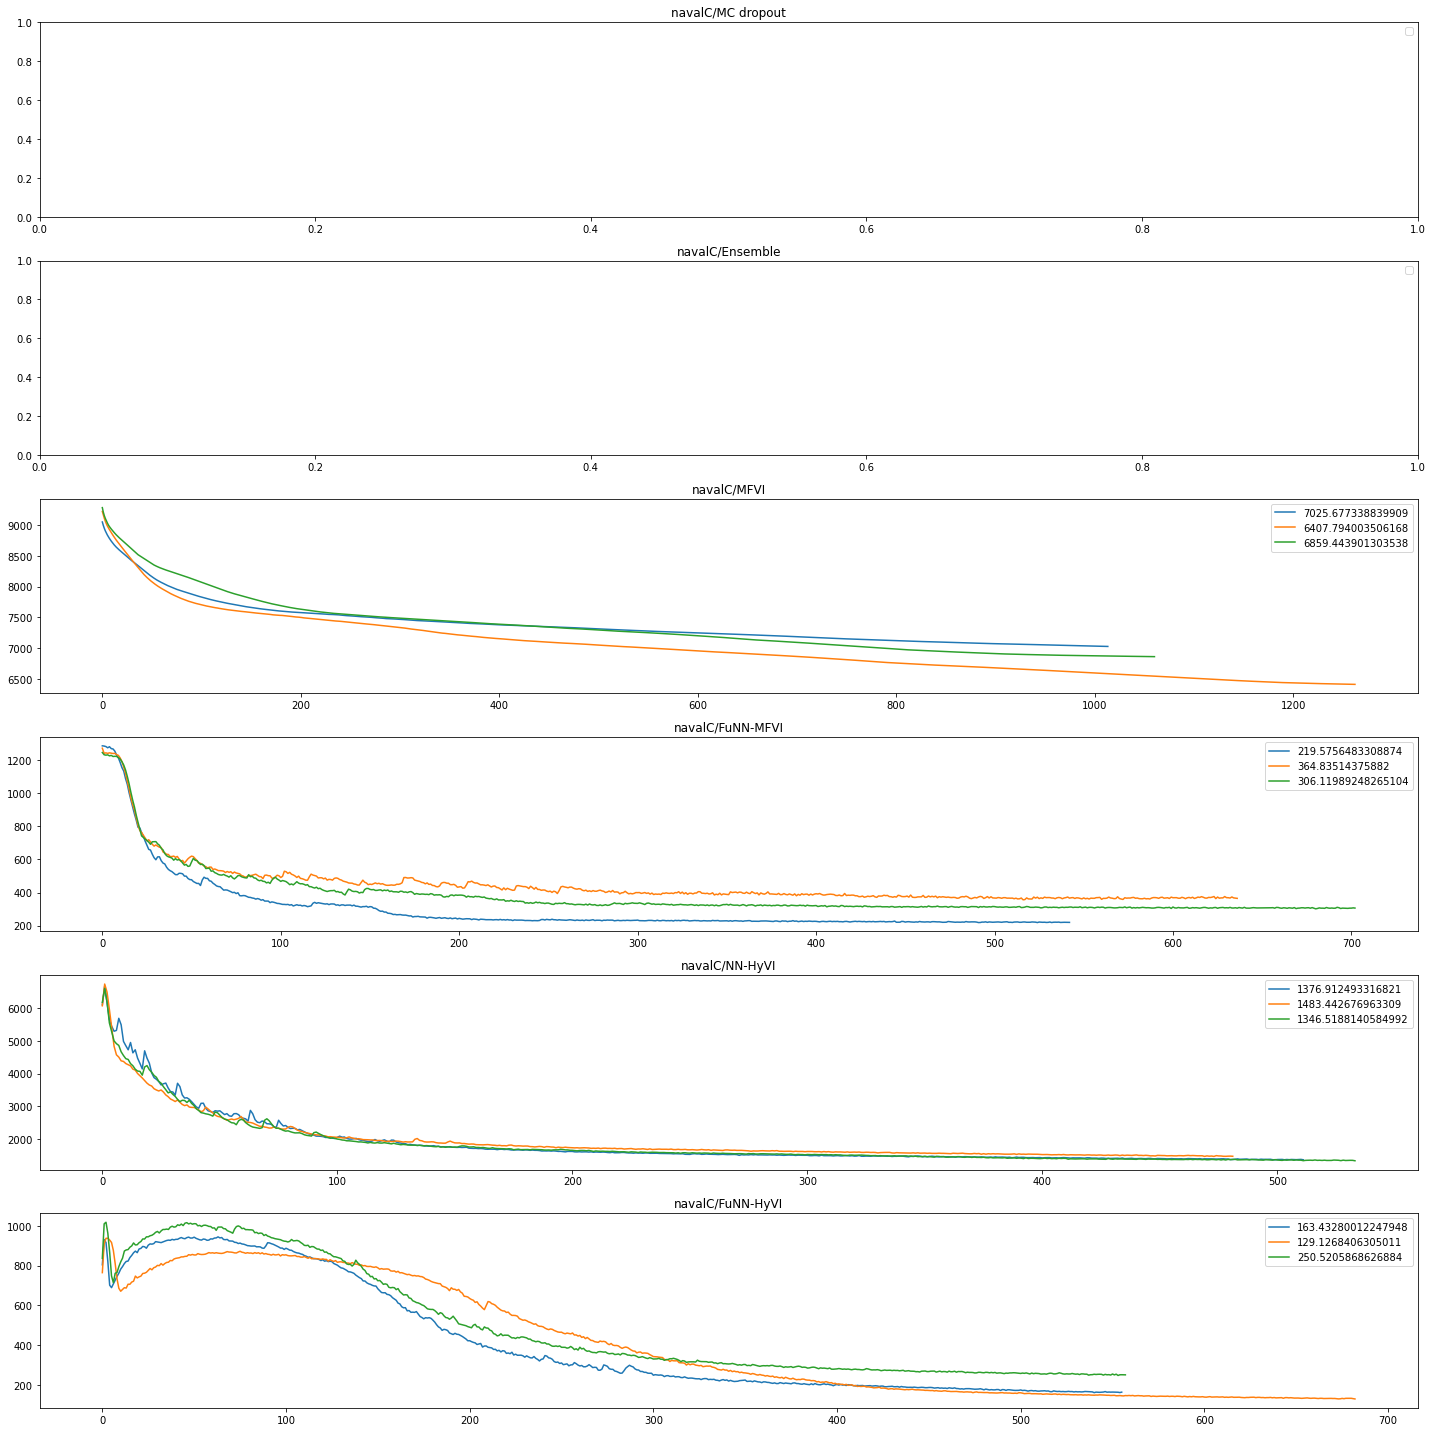

In [19]:
from pylab import *
datasets_=['navalC']
fig, ax=plt.subplots(len(methods), len(datasets_), figsize=(20,20))
ax=ax.flatten()
i=0

for method in methods:
    for dataset in datasets_:
        for split in MODELS[dataset]: 
            logs=split[1][method][1]
            for key in logs.keys():
                if key=='KL':# or key=='loss' or key=='LL' or isinstance(key, int): 
                    ax[i].plot(range(len(logs[key])), logs[key], label="{}".format(logs[key][-1]))
                ax[i].legend()
                ax[i].set_title(dataset+'/'+method)
        i+=1

fig.tight_layout()

# OOD detection

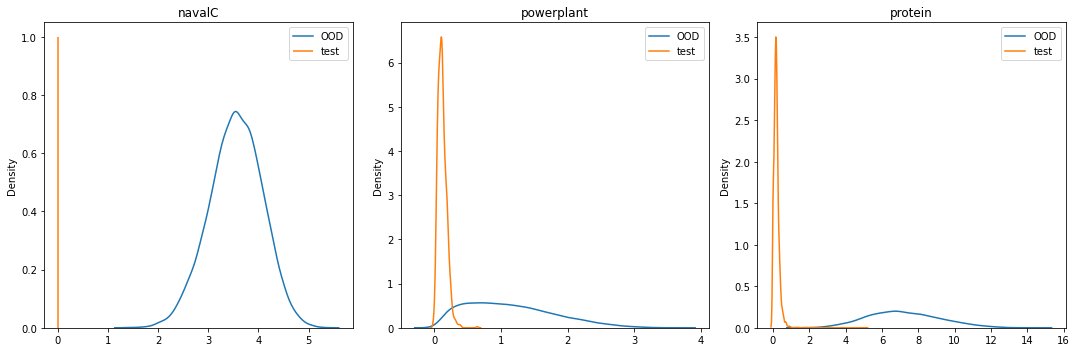

In [20]:
import seaborn as sns
from pylab import *
from torch.distributions import MultivariateNormal
from matplotlib.colors import ListedColormap

cmap=ListedColormap(sns.color_palette("tab10").as_hex())


def nn_dist(X):
    #X_in=torch.cat([X[0],X[1]])
    X_train=X[0]
    X_test=X[1]
    X_ood=X[2]
    dist_ood=torch.cdist(X_train,X_ood)
    dist_test=torch.cdist(X_train,X_test)
    #print(X_in.shape, X_ood.shape, dist.shape)
    return dist_test.min(dim=0)[0], dist_ood.min(dim=0)[0]

fig, ax=plt.subplots(1,3, figsize=(15,5))
ax=ax.flatten()
i=0
for dataset in datasets:
    split_nb=0
    for split in MODELS[dataset]:#[MODELS[dataset][0]]:
        split_nb+=1
        x_train, y_train=split[0]['train']
        x_test, y_test=split[0]['test']
        input_dim=x_test.shape[1]
        std_y_train=split[0]['scaler_y']
        
        OOD_sampler = uniform_rect_sampler(x_train, n=10000) #MultivariateNormal(x_train.mean(0), covariance_matrix=.5*torch.diag(x_train.std(0))) #
        x_OOD=OOD_sampler()#OOD_sampler.sample((50000,))
        
        X = [x_train, x_test, x_OOD]
        if split_nb==2:
            test, ood= nn_dist(X)
            sns.kdeplot(ood.cpu(), ax=ax[i], label='OOD')
            ax[i].set_title(dataset)
            if test.std() < 0.01:
                ax[i].vlines(x=test.mean(), ymin=0, ymax=1, color=cmap(1), label='test')
            else:
                sns.kdeplot(test.cpu(), ax=ax[i], label='test')
            ax[i].legend()
            i+=1
fig.tight_layout()

In [21]:
import seaborn as sns
from pylab import *
import math
from Tools import uniform_rect_sampler
from Metrics import batch_entropy_nne

VARs={dataset:{method: [] for method in methods} for dataset in datasets}
#Hs=torch.load(path+'_epist_entropy_50k.pt')
#MODELS.to(device)
def VAR(model, X):
#    return [torch.cat([batch_entropy_nne(model(x_, 1000).detach().transpose(0,1), k=1) for x_ in x.split(500,dim=0)],dim=0) for x in X]
    return [torch.cat([model(x_, 1000).detach().std(0).squeeze() for x_ in x.split(500,dim=0)],dim=0) for x in X]


n_ood=10000
for dataset in datasets:
    print(dataset)
    split_nb=0
    for split in MODELS[dataset]:#[MODELS[dataset][0]]:
        print(split_nb)
        split_nb+=1
        x_train, y_train=split[0]['train']
        x_test, y_test=split[0]['test']
        input_dim=x_test.shape[1]
        std_y_train=split[0]['scaler_y']
        
        OOD_sampler = uniform_rect_sampler(x_train, n=n_ood) #MultivariateNormal(x_train.mean(0), covariance_matrix=.5*torch.diag(x_train.std(0))) #
        x_OOD=OOD_sampler() #OOD_sampler.sample((n_ood,))#
        
        X = [x_train, x_test, x_OOD]
        method="Ensemble"
        model = ensemble(input_dim, layerwidth, activation, num_models=5).to(device)
        model.load_state_dict(split[1][method][0])
        Y = [model(x) for x in X]
        VARs[dataset][method].append([y.std(0).squeeze() for y in Y])

        method="MC dropout"
        model = MC_Dropout(input_dim, 1, layerwidth, init_sigma_noise=1., drop_prob=0.05, learn_noise=True,
                               activation=activation).to(device)
        model.load_state_dict(split[1][method][0])
        Y=[torch.cat([model.predict(x_, 1000).detach() for x_ in x.split(500,dim=0)],dim=1) for x in X]
        #Y=[model.predict(x, 1000) for x in X]
        VARs[dataset][method].append([y.std(0).squeeze() for y in Y])
         
        method="MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        VARs[dataset][method].append(VAR(model,X))
        
        method="NN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        VARs[dataset][method].append(VAR(model,X))

        
        method="FuNN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        VARs[dataset][method].append(VAR(model,X))
        
        method="FuNN-MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        VARs[dataset][method].append(VAR(model,X))
        
#         predictor=model.predictor
#         method='HMC'
#         HMC_=models_HMC[dataset]
#         indices = torch.randperm(len(HMC_))[:1000]
#         theta=HMC_[indices].to(device)
#         VARs[dataset][method].append([torch.cat([predictor(x_, theta).detach().std(0).squeeze() for x_ in x.split(500,dim=0)],dim=0) for x in X])
        
        torch.save(VARs,path+'_epist_VAR_10k.pt')

navalC
0
1
2
powerplant
0
1
2
protein
0
1
2


In [22]:
from sklearn.metrics import roc_curve, roc_auc_score
from pylab import *
import numpy as np
cmap=plt.get_cmap('Set1')
Hs=torch.load(path+'_epist_VAR_10k.pt')
roc_data={dataset:{} for dataset in datasets}
AUC={}#{dataset:{} for dataset in datsets}

n_ood=10000
fpr=torch.arange(n_ood).true_divide(n_ood)

for dataset in datasets:     
    for method in methods:
        AUCs=[]

        TPRs=[]

        for h in Hs[dataset][method]:
            H_in=torch.cat([h[0],h[1]]).cpu()
            H_ood, _=h[2].cpu().sort()
            
            TPRs.append((H_in.unsqueeze(-1) < H_ood).sum(0).true_divide(len(H_in)))

            y_true=torch.cat([torch.ones_like(torch.cat([h[0],h[1]])),torch.zeros_like(h[2])])
            y_score=-torch.cat([h[0],h[1],h[2]])
            AUCs.append(roc_auc_score(y_true.cpu(), y_score.cpu()))

        roc_data[dataset].update({method: {'AUC':np.mean(AUCs),'tpr_mean': torch.stack(TPRs).mean(0), 'tpr_min':torch.stack(TPRs).min(0)[0], 'tpr_max':torch.stack(TPRs).max(0)[0]}})

        print(dataset+"/"+method+": {}".format(np.mean(AUCs)))

navalC/MC dropout: 0.9999999888274398
navalC/Ensemble: 0.9999995251661918
navalC/MFVI: 0.8669351530640745
navalC/FuNN-MFVI: 0.9578163021618903
navalC/NN-HyVI: 1.0
navalC/FuNN-HyVI: 1.0
powerplant/MC dropout: 0.9143554992335563
powerplant/Ensemble: 0.9335099515746935
powerplant/MFVI: 0.8635425080128206
powerplant/FuNN-MFVI: 0.9335283253205127
powerplant/NN-HyVI: 0.9571745941332219
powerplant/FuNN-HyVI: 0.9626452637263099
protein/MC dropout: 0.9998808047233764
protein/Ensemble: 0.999911274874262
protein/MFVI: 0.9987747364968292
protein/FuNN-MFVI: 0.9966291165536848
protein/NN-HyVI: 0.9999938705445004
protein/FuNN-HyVI: 0.9999976302937532


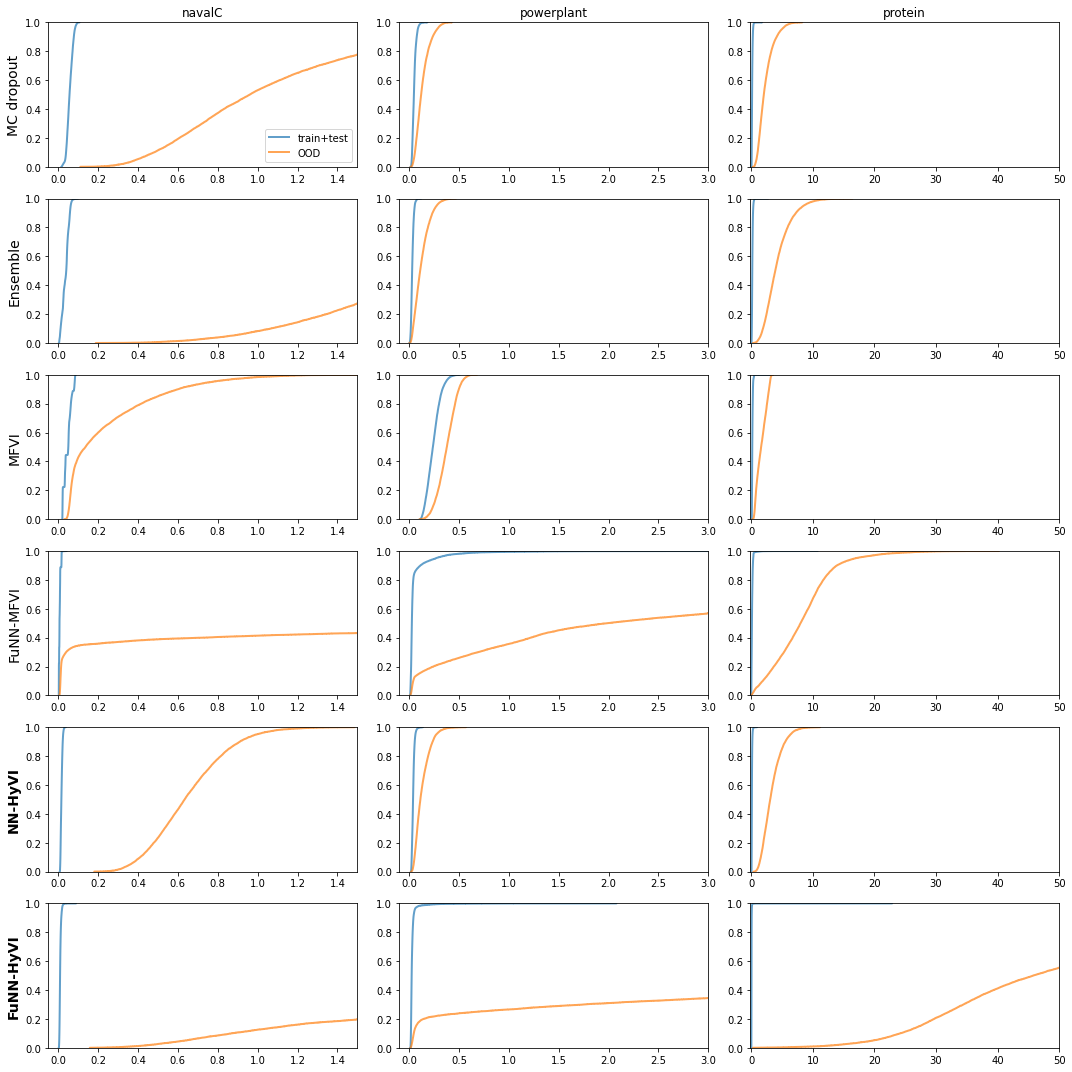

In [23]:
from pylab import *
import seaborn as sns
import pandas as pd
from matplotlib.colors import ListedColormap

parameters = {'axes.labelsize':14,
              'axes.titlesize': 12,
              'xtick.labelsize' : 10,
              'ytick.labelsize' : 10,
              'figure.titlesize':14}
plt.rcParams.update(parameters)
Hs=torch.load(path+'_epist_VAR_10k.pt')
n_datasets=len(datasets)
n_methods=len(methods)
fig,ax=plt.subplots(n_methods,n_datasets,figsize=(15,15),squeeze=False)

data_type=['train+test', 'OOD']
method_names=['MC dropout','Ensemble','MFVI','FuNN-MFVI','NN-HyVI','FuNN-HyVI']

right=[1.5,3.,50.]
left=[-.05,-.1,-.2]
split=2
cmap=ListedColormap(sns.color_palette("tab10").as_hex())
d=0
for dataset in datasets:
    m=0
    ax[m,d].set_title(dataset)
    for method in methods:
        H_=Hs[dataset][method][split]
        H=[torch.cat([H_[0],H_[1]]), H_[2]]
        #for i in range(len(H)):
        #data=pd.DataFrame([pd.DataFrame(H[i].cpu(), columns=[data_type[i]]) for i in range(3)], columns=['type'])
        #print(data)
        #print(data)
 #       data=pd.concat([pd.Series(H[0].cpu(),name='train'),pd.Series(H[1].cpu(),name='test'),pd.Series(H[2].cpu(),name='OOD')], axis=0, join='inner')
#        print(data)
        for i in range(len(H)):
            #sns.histplot(H[i].cpu(), stat='density', element='step', alpha = .7, kde=True, color=cmap(i), label=data_type[i],ax=ax[m,d])#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],
            sns.ecdfplot(H[i].cpu(),color=cmap(i), label=data_type[i],ax=ax[m,d],lw=2, alpha=.7)#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],

        if (m,d) == (0,0): 
            ax[m,d].legend()#.remove()
        ax[m,d].set_xlim(left=left[d], right=right[d])
        ax[m,d].set_ylabel('')
        if d ==0:
            if method=='FuNN-HyVI' or method== 'NN-HyVI' or method== 'FuNN-HyVI*':
                ax[m,d].set_ylabel(method, {'fontweight':'bold'})
            else:
                ax[m,d].set_ylabel(method)
        m+=1

    d+=1
#ax[3,2].legend(loc='upper right', prop={'size': 8})#bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
fig.tight_layout()
fig.align_ylabels(ax[:, 0])
plt.savefig(path+"_EpistVarECDF_Exp2-{}.pdf".format(split), dpi=600)
#plt.subplots_adjust(top=.9)
#plt.suptitle('Posterior Predictive Entropy Distributions')
plt.show()

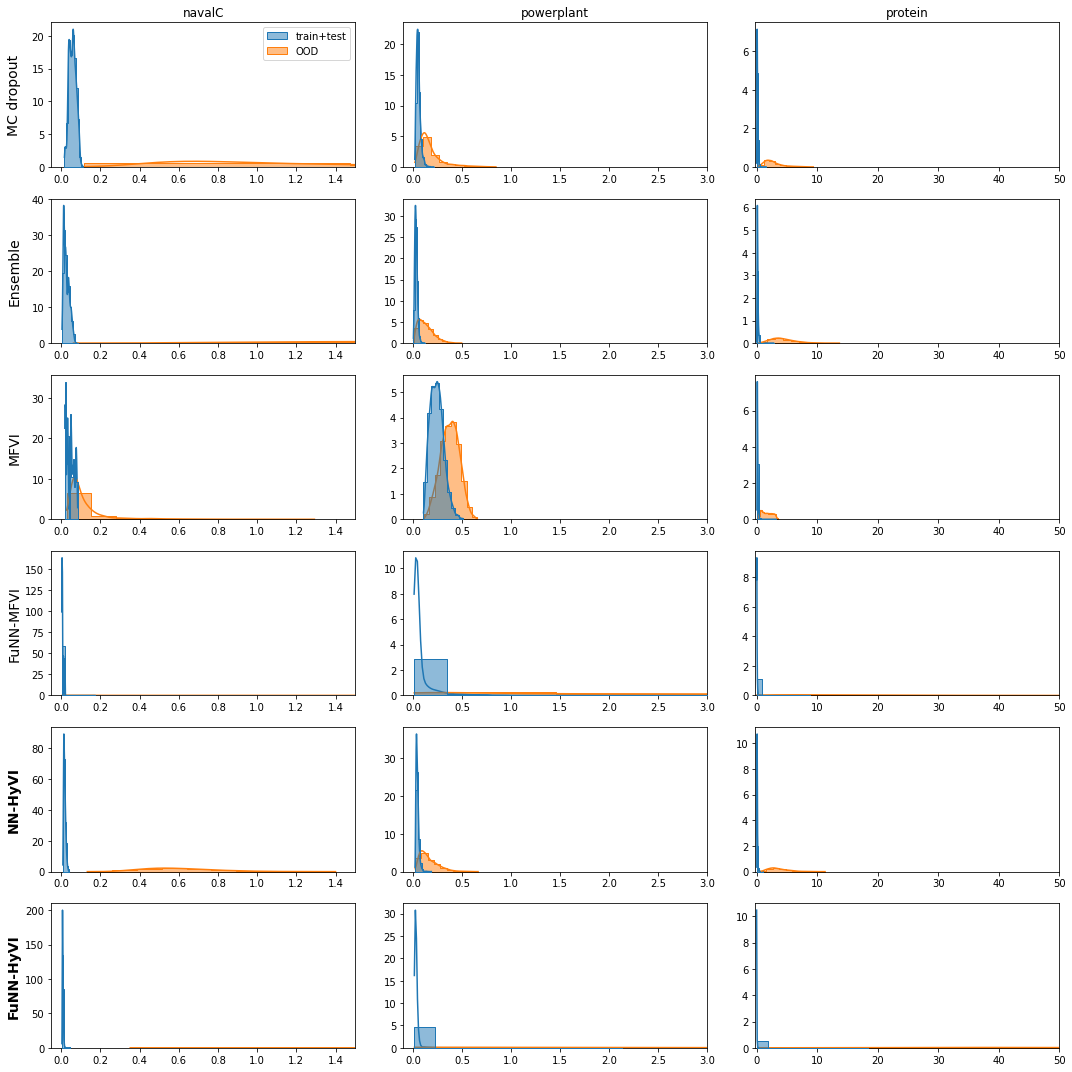

In [24]:
from pylab import *
import seaborn as sns
import pandas as pd
from matplotlib.colors import ListedColormap

parameters = {'axes.labelsize':14,
              'axes.titlesize': 12,
              'xtick.labelsize' : 10,
              'ytick.labelsize' : 10,
              'figure.titlesize':14}
plt.rcParams.update(parameters)
Hs=torch.load(path+'_epist_VAR_10k.pt')
n_datasets=len(datasets)
n_methods=len(methods)
fig,ax=plt.subplots(n_methods,n_datasets,figsize=(15,15),squeeze=False)

data_type=['train+test', 'OOD']
method_names=['MC dropout','Ensemble','MFVI','FuNN-MFVI','NN-HyVI','FuNN-HyVI']

split=1
cmap=ListedColormap(sns.color_palette("tab10").as_hex())
d=0
right=[1.5,3.,50.]
left=[-.05,-.1,-.2]
for dataset in datasets:
    m=0
    max_var=[]
    ax[m,d].set_title(dataset)
    for method in methods:
        H_=Hs[dataset][method][split]
        H=[torch.cat([H_[0],H_[1]]), H_[2]]

        #for i in range(len(H)):
        #data=pd.DataFrame([pd.DataFrame(H[i].cpu(), columns=[data_type[i]]) for i in range(3)], columns=['type'])
        #print(data)
        #print(data)
 #       data=pd.concat([pd.Series(H[0].cpu(),name='train'),pd.Series(H[1].cpu(),name='test'),pd.Series(H[2].cpu(),name='OOD')], axis=0, join='inner')
#        print(data)
        for i in range(len(H)):
            max_var.append(H[i].max().cpu())
            sns.histplot(H[i].cpu(), stat='density', bins=10, element='step', alpha = .5, kde=True, color=cmap(i), label=data_type[i],ax=ax[m,d], zorder=3-i)#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],
            #sns.ecdfplot(H[i].cpu(),color=cmap(i), label=data_type[i],ax=ax[m,d],lw=2, alpha=.7)#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],

        if (m,d) == (0,0): 
            ax[m,d].legend()#.remove()
        ax[m,d].set_ylabel('')
        if d ==0:
            if method=='FuNN-HyVI' or method== 'NN-HyVI' or method== 'FuNN-HyVI*':
                ax[m,d].set_ylabel(method, {'fontweight':'bold'})
            else:
                ax[m,d].set_ylabel(method)
        m+=1
    for m in range(n_methods):
        ax[m,d].set_xlim(left=left[d], right=right[d])#np.max(max_var))

    d+=1
#ax[3,2].legend(loc='upper right', prop={'size': 8})#bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
fig.tight_layout()
fig.align_ylabels(ax[:, 0])
plt.savefig(path+"_EpistVarDist_Exp2-{}.pdf".format(split), dpi=600)
#plt.subplots_adjust(top=.9)
#plt.suptitle('Posterior Predictive Entropy Distributions')
plt.show()

MC dropout
Ensemble
MFVI
FuNN-MFVI
NN-HyVI
FuNN-HyVI


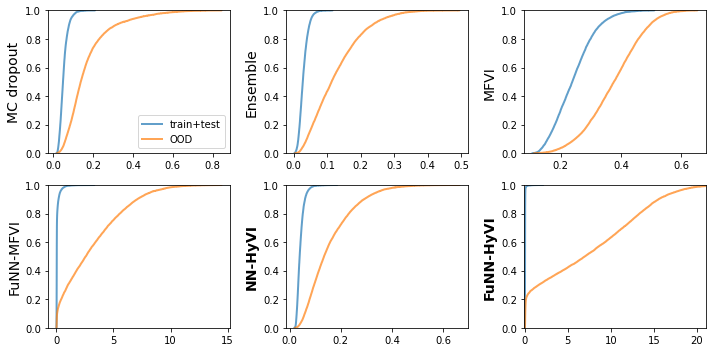

In [25]:
from pylab import *
import seaborn as sns
import pandas as pd
from matplotlib.colors import ListedColormap

parameters = {'axes.labelsize':14,
              'axes.titlesize': 12,
              'xtick.labelsize' : 10,
              'ytick.labelsize' : 10,
              'figure.titlesize':14}
plt.rcParams.update(parameters)
Hs=torch.load(path+'_epist_VAR_10k.pt')

n_methods=len(methods)
fig,ax=plt.subplots(2,3,figsize=(10,5),squeeze=True)
ax=ax.flatten()
data_type=['train+test', 'OOD']
method_names=['MC dropout','Ensemble','MFVI','FuNN-MFVI','NN-HyVI','FuNN-HyVI']

split=1
cmap=ListedColormap(sns.color_palette("tab10").as_hex())
d=0
for dataset in ['powerplant']:
    m=0
    max_var=[]
    #ax.set_title(dataset)
    for method in methods:
        H_=Hs[dataset][method][split]
        H=[torch.cat([H_[0],H_[1]]), H_[2]]
        #for i in range(len(H)):
        #data=pd.DataFrame([pd.DataFrame(H[i].cpu(), columns=[data_type[i]]) for i in range(3)], columns=['type'])
        #print(data)
        #print(data)
 #       data=pd.concat([pd.Series(H[0].cpu(),name='train'),pd.Series(H[1].cpu(),name='test'),pd.Series(H[2].cpu(),name='OOD')], axis=0, join='inner')
#        print(data)
        print(method)
        
        for i in range(len(H)):
            max_var.append(H[i].max().cpu())
            #sns.histplot(H[i].cpu(), stat='density', bins=10, element='step', alpha = .5, kde=True, color=cmap(i), label=data_type[i],ax=ax[m], zorder=3-i)#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],
            sns.ecdfplot(H[i].pow(1).cpu(),color=cmap(i), label=data_type[i],ax=ax[m],lw=2, alpha=.7)#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],

        if m==0: 
            ax[m].legend()#.remove()
        ax[m].set_ylabel('')
        if d ==0:
            if method=='FuNN-HyVI' or method== 'NN-HyVI' or method== 'FuNN-HyVI*':
                ax[m].set_ylabel(method, {'fontweight':'bold'})
            else:
                ax[m].set_ylabel(method)
        m+=1
#    for m in range(n_methods):
#        ax[m].set_xlim(left=-.1, right=20)
        #ax[m].set_ylim(bottom=0., top=1.1)

    d+=1
ax[5].set_xlim(left=-.1, right=21)

#ax[3,2].legend(loc='upper right', prop={'size': 8})#bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
fig.tight_layout()
#fig.align_ylabels(ax[:, 0])
plt.savefig(path+"_EpistVarECDF_Exp2-{}.pdf".format(dataset), dpi=600)
#plt.subplots_adjust(top=.9)
#plt.suptitle('Posterior Predictive Entropy Distributions')
plt.show()

<ipython-input-26-bd0856e6c9e8>:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


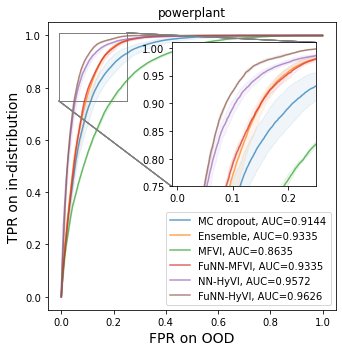

In [26]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes, mark_inset
from matplotlib.colors import ListedColormap

from pylab import *
import seaborn as sns
l=1
fig, ax= plt.subplots(1,l,figsize=(5*l,5))
dataset='powerplant'
cmap=ListedColormap(sns.color_palette("tab10").as_hex())
R=[0.25]
B=[ 0.75]
ax=[ax]
def add_zero(x):
    return torch.cat([torch.zeros(1,1),x.view(-1,1)]).squeeze()
fpr=add_zero(torch.arange(n_ood).true_divide(n_ood))
d=0
for dataset in [dataset]:
    c=0

    zoom_ax = inset_axes(ax[d], width=2, height=2,  loc='upper right',borderpad=2)      
    for method in methods:
        AUC=roc_data[dataset][method]['AUC']
        tpr_mean=add_zero(roc_data[dataset][method]['tpr_mean'])
        tpr_min=add_zero(roc_data[dataset][method]['tpr_min'])
        tpr_max=add_zero(roc_data[dataset][method]['tpr_max'])
        ax[d].plot(fpr, tpr_mean, alpha=0.7, label=method+", AUC={:.4f}".format(AUC), color=cmap(c))
        ax[d].fill_between(fpr, tpr_min, tpr_max, alpha=0.07, color=cmap(c))

        zoom_ax.plot(fpr, tpr_mean, alpha=0.7, label=method+", AUC={:.4f}".format(AUC), color=cmap(c))
        zoom_ax.fill_between(fpr, tpr_min, tpr_max, alpha=0.07, color=cmap(c))  
        mark_inset(ax[d], zoom_ax, loc1=1, loc2=3, fc="none", ec="0.5")

        c+=1
    zoom_ax.set_xlim(left=-0.01, right=R[d])
    zoom_ax.set_ylim(bottom=B[d], top=1.01)
    zoom_ax.legend().remove()
    zoom_ax.set_xlabel('')
    zoom_ax.set_ylabel('')
    zoom_ax.set_aspect('equal')
    ax[d].legend()
    ax[d].set_title(dataset)
    ax[d].set_xlabel('FPR on OOD')
    ax[d].set_ylabel('TPR on in-distribution')
    ax[d].set_xlim(left=-0.05, right=1.05)
    ax[d].set_ylim(bottom=-.05, top=1.05)
    ax[d].set_aspect('equal')

    d+=1


fig.tight_layout()
plt.savefig(path+"_ROC_curves_{}.pdf".format(dataset), dpi=600)


<ipython-input-27-f78ab1e6d262>:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


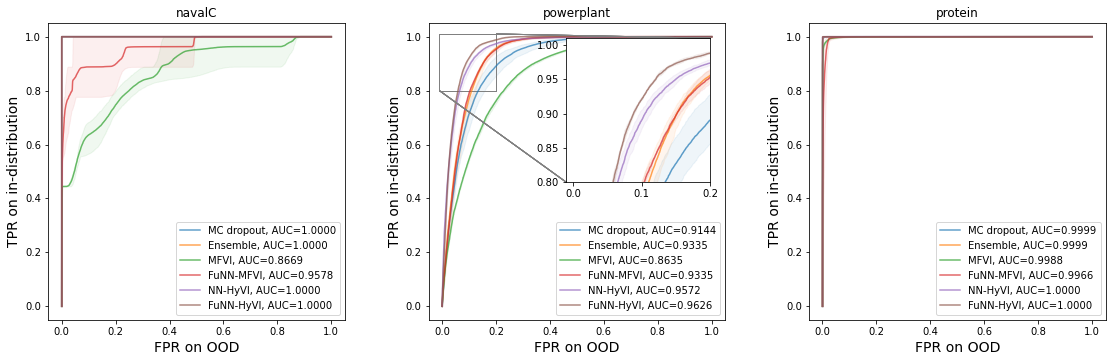

In [27]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes, mark_inset
from matplotlib.colors import ListedColormap

from pylab import *
import seaborn as sns
l=len(datasets)
fig, ax= plt.subplots(1,l,figsize=(5*l+1,5))
d=0
cmap=ListedColormap(sns.color_palette("tab10").as_hex())
R=[0.2 for _ in range(6)]
B=[0.8 for _ in range(6)]

methods=['MC dropout','Ensemble','MFVI', 'FuNN-MFVI', 'NN-HyVI', 'FuNN-HyVI']

def add_zero(x):
    return torch.cat([torch.zeros(1,1),x.view(-1,1)]).squeeze()
fpr=add_zero(torch.arange(n_ood).true_divide(n_ood))
colors=[]
for dataset in datasets:
    c=0
    if dataset == 'powerplant': 
        zoom_ax = inset_axes(ax[d], width=2, height=2,  loc='upper right', borderpad=1.5)      
    for method in methods:
        AUC=roc_data[dataset][method]['AUC']
        tpr_mean=add_zero(roc_data[dataset][method]['tpr_mean'])
        tpr_min=add_zero(roc_data[dataset][method]['tpr_min'])
        tpr_max=add_zero(roc_data[dataset][method]['tpr_max'])
        ax[d].plot(fpr, tpr_mean, alpha=0.7, label=method+", AUC={:.4f}".format(AUC), color=cmap(c))
        ax[d].fill_between(fpr, tpr_min, tpr_max, alpha=0.07, color=cmap(c))
        if dataset == 'powerplant': 
            zoom_ax.plot(fpr, tpr_mean, alpha=0.7, label=method+", AUC={:.4f}".format(AUC), color=cmap(c))
            zoom_ax.fill_between(fpr, tpr_min, tpr_max, alpha=0.07, color=cmap(c))  
            mark_inset(ax[d], zoom_ax, loc1=1, loc2=3, fc="none", ec="0.5")

        c+=1
    if dataset == 'powerplant': 
        zoom_ax.set_xlim(left=-0.01, right=R[d])
        zoom_ax.set_ylim(bottom=B[d], top=1.01)
        zoom_ax.legend().remove()
        zoom_ax.set_xlabel('')
        zoom_ax.set_ylabel('')
        zoom_ax.set_aspect('equal')
    ax[d].legend()
    ax[d].set_title(dataset)
    ax[d].set_xlabel('FPR on OOD')
    ax[d].set_ylabel('TPR on in-distribution')
    ax[d].set_xlim(left=-0.05, right=1.05)
    ax[d].set_ylim(bottom=-.05, top=1.05)
    ax[d].set_aspect('equal')

    d+=1


fig.tight_layout()
plt.savefig(path+"ROC_curves_VAR_MinMax.pdf", dpi=600)


# Parametric vs Predictor Entropy

In [28]:
from Metrics import entropy_nne
def FunH(model, sampler, n=100, n_MC=200):
    Hs=[entropy_nne(model(sampler()).squeeze(2), k=1, k_MC=n_MC).item() for _ in range(n)]
    return np.mean(Hs)



In [29]:
import seaborn as sns
from pylab import *
import math
from Tools import uniform_rect_sampler
from Metrics import batch_entropy_nne

Hs={dataset:{} for dataset in datasets}

def Entropy(model, X):
    return [torch.cat([batch_entropy_nne(model(x_, 1000).detach().transpose(0,1), k=1) for x_ in x.split(500,dim=0)],dim=0) for x in X]

def univariate_gaussian_entropy(sigma=None, var=None):
    if sigma is not None:
        return 0.5*torch.log(2*math.pi*math.e*sigma**2)
    if var is not None:
        return 0.5*torch.log(2*math.pi*math.e*var)

nb_predictors=1000    
n_MC=200
    
for dataset in datasets:
    print(dataset)
    split_nb=0
    Hs[dataset].update({(method,'parameter'):[] for method in methods})
    Hs[dataset].update({(method,'predictor'):[] for method in methods})

    for split in MODELS[dataset]:#[MODELS[dataset][0]]:
        print(split_nb)
        split_nb+=1
        x_train, y_train=split[0]['train']
        x_test, y_test=split[0]['test']
        input_dim=x_test.shape[1]
        std_y_train=split[0]['scaler_y']
        
        OOD_sampler = uniform_rect_sampler(x_train, n=n_MC)
        x_OOD=OOD_sampler()
        
        X = [x_train, x_test, x_OOD]
        method="Ensemble"
        model = ensemble(input_dim, layerwidth, activation, num_models=5).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][(method,'parameter')].append(entropy_nne(model.get_parameters, k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(model, OOD_sampler, n=100, n_MC=200))

        method="MC dropout"
        model = MC_Dropout(input_dim, 1, layerwidth, init_sigma_noise=1., drop_prob=0.05, learn_noise=True,
                               activation=activation).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][(method,'predictor')].append(FunH(lambda x: model.predict(x,nb_predictors), OOD_sampler, n=100, n_MC=200))
         
        method="MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][(method,'parameter')].append(entropy_nne(model.gen(nb_predictors), k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(lambda x: model(x,nb_predictors=nb_predictors), OOD_sampler, n=100, n_MC=200))
        
        method="NN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][(method,'parameter')].append(entropy_nne(model.gen(nb_predictors), k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(lambda x: model(x,nb_predictors=nb_predictors), OOD_sampler, n=100, n_MC=200))

        
        method="FuNN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][(method,'parameter')].append(entropy_nne(model.gen(nb_predictors), k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(lambda x: model(x,nb_predictors=nb_predictors), OOD_sampler, n=100, n_MC=200))
        
        method="FuNN-MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][(method,'parameter')].append(entropy_nne(model.gen(nb_predictors), k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(lambda x: model(x,nb_predictors=nb_predictors), OOD_sampler, n=100, n_MC=200))
        
#         predictor=model.predictor
#         method='HMC'
#         HMC_=models_HMC[dataset]
#         indices = torch.randperm(len(HMC_))[:1000]
#         theta=HMC_[indices].to(device)
#         Hs[dataset][(method,'parameter')].append(entropy_nne(theta, k=1, k_MC=1).item())
#         Hs[dataset][(method,'predictor')].append(FunH(lambda x: predictor(x,theta), OOD_sampler, n=100, n_MC=200))
   

navalC
0
1
2
powerplant
0
1
2
protein
0
1
2


In [30]:
torch.save(Hs,path+'_ParamVsPredictor_entropy_0_1.pt')
Hs=torch.load(path+'_ParamVsPredictor_entropy_0_1.pt')


In [31]:
import pandas as pd
import numpy as np
H_mean={} 
H_std={}
for dataset, value in Hs.items():
    #print(dataset)
    H_mean.update({dataset:{}})
    H_std.update({dataset:{}})
    for key2, results in value.items():
        #print(key2)
        H_mean[dataset].update({key2:np.mean(results)})
        H_std[dataset].update({key2:np.std(results)})

/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [32]:
methods_=['HMC','MC dropout', 'Ensemble', 'MFVI', 'FuNN-MFVI', 'NN-HyVI', 'FuNN-HyVI']
index=pd.MultiIndex.from_product([methods_,["parameter"]])
df=pd.DataFrame(H_mean, index=index).transpose()
df_=pd.DataFrame(H_std, index=index).transpose()
df.style.background_gradient(axis=1,cmap='viridis')

,HMC,MC dropout,Ensemble,MFVI,FuNN-MFVI,NN-HyVI,FuNN-HyVI
,parameter,parameter,parameter,parameter,parameter,parameter,parameter
navalC,nan,nan,635.987142,-399.887858,-2553.118896,1725.720540,-4777.470052
powerplant,nan,nan,286.244385,366.202759,-831.852681,1066.439657,52.515747
protein,nan,nan,1204.512126,788.332845,-2189.062337,2313.736979,-1221.876587


In [33]:
for i in df.columns:
    df[i] = df[i].round().astype(str)+ "±" + (df_[i].round()).astype(str)+""

print(df.to_latex())

\begin{tabular}{llllllll}
\toprule
{} &       HMC & MC dropout &    Ensemble &          MFVI &       FuNN-MFVI &      NN-HyVI &      FuNN-HyVI \\
{} & parameter &  parameter &   parameter &     parameter &       parameter &    parameter &      parameter \\
\midrule
navalC     &   nan±nan &    nan±nan &  636.0±11.0 &  -400.0±174.0 &  -2553.0±1677.0 &  1726.0±85.0 &  -4777.0±298.0 \\
powerplant &   nan±nan &    nan±nan &   286.0±5.0 &     366.0±1.0 &    -832.0±117.0 &  1066.0±12.0 &      53.0±21.0 \\
protein    &   nan±nan &    nan±nan &  1205.0±9.0 &     788.0±3.0 &   -2189.0±438.0 &  2314.0±22.0 &  -1222.0±191.0 \\
\bottomrule
\end{tabular}



In [34]:
pd.DataFrame(H_std, index=index).transpose()

,HMC,MC dropout,Ensemble,MFVI,FuNN-MFVI,NN-HyVI,FuNN-HyVI
,parameter,parameter,parameter,parameter,parameter,parameter,parameter
navalC,NaN,NaN,10.752016,174.462643,1677.191044,85.336734,298.496395
powerplant,NaN,NaN,5.248519,0.872690,117.102436,11.857065,20.718382
protein,NaN,NaN,9.242270,3.087619,437.513575,22.459697,190.631089


In [35]:
index=pd.MultiIndex.from_product([methods_,["predictor"]])
df=pd.DataFrame(H_mean, index=index).transpose()
df_=pd.DataFrame(H_std, index=index).transpose()
df_s=df.style.background_gradient(axis=1,cmap='viridis')
df_s

,HMC,MC dropout,Ensemble,MFVI,FuNN-MFVI,NN-HyVI,FuNN-HyVI
,predictor,predictor,predictor,predictor,predictor,predictor,predictor
navalC,nan,-166.933500,-62.410522,-719.415520,135.760281,-511.438653,12.119243
powerplant,nan,-606.945497,-598.273573,-571.413367,-73.732543,-760.079617,168.967278
protein,nan,-17.980616,92.831458,-367.061991,155.298583,-71.193348,372.216526


In [36]:
for i in df.columns:
    df[i] = df[i].round().astype(str)+ "±" + (df_[i].round()).astype(str)+""

print(df.to_latex())

\begin{tabular}{llllllll}
\toprule
{} &       HMC &   MC dropout &     Ensemble &         MFVI &   FuNN-MFVI &      NN-HyVI &   FuNN-HyVI \\
{} & predictor &    predictor &    predictor &    predictor &   predictor &    predictor &   predictor \\
\midrule
navalC     &   nan±nan &   -167.0±1.0 &    -62.0±9.0 &  -719.0±77.0 &  136.0±95.0 &  -511.0±14.0 &   12.0±50.0 \\
powerplant &   nan±nan &  -607.0±33.0 &  -598.0±11.0 &   -571.0±1.0 &   -74.0±3.0 &  -760.0±10.0 &   169.0±8.0 \\
protein    &   nan±nan &   -18.0±13.0 &     93.0±2.0 &  -367.0±28.0 &  155.0±76.0 &    -71.0±4.0 &  372.0±16.0 \\
\bottomrule
\end{tabular}



# VAR vs Entropy


In [37]:
def Entropy(model, X):
    return [torch.cat([batch_entropy_nne(model(x_, 1000).detach().transpose(0,1), k=1) for x_ in x.split(500,dim=0)],dim=0) for x in X]


def univariate_gaussian_entropy(sigma=None, var=None):
    if sigma is not None:
        return 0.5*torch.log(2*math.pi*math.e*sigma**2)
    if var is not None:
        return 0.5*torch.log(2*math.pi*math.e*var)
    


import seaborn as sns
from pylab import *
import math
from Tools import uniform_rect_sampler
from Metrics import batch_entropy_nne

ENTs={dataset:{method: [] for method in methods} for dataset in datasets}
#Hs=torch.load(path+'_epist_entropy_50k.pt')
#MODELS.to(device)
def VAR(model, X):
#    return [torch.cat([batch_entropy_nne(model(x_, 1000).detach().transpose(0,1), k=1) for x_ in x.split(500,dim=0)],dim=0) for x in X]
    return [torch.cat([model(x_, 1000).detach().std(0).squeeze() for x_ in x.split(500,dim=0)],dim=0) for x in X]


n_ood=10000
for dataset in datasets:
    print(dataset)
    split_nb=0
    for split in MODELS[dataset]:#[MODELS[dataset][0]]:
        print(split_nb)
        split_nb+=1
        x_train, y_train=split[0]['train']
        x_test, y_test=split[0]['test']
        input_dim=x_test.shape[1]
        std_y_train=split[0]['scaler_y']
        
        OOD_sampler = uniform_rect_sampler(x_train, n=n_ood) #MultivariateNormal(x_train.mean(0), covariance_matrix=.5*torch.diag(x_train.std(0))) #
        x_OOD=OOD_sampler() #OOD_sampler.sample((n_ood,))#
        
        X = [x_train, x_test, x_OOD]
        method="Ensemble"
        model = ensemble(input_dim, layerwidth, activation, num_models=5).to(device)
        model.load_state_dict(split[1][method][0])
        Y = [model(x) for x in X]
        ENTs[dataset][method].append([univariate_gaussian_entropy(sigma=y.std(0).squeeze()) for y in Y])

        method="MC dropout"
        model = MC_Dropout(input_dim, 1, layerwidth, init_sigma_noise=1., drop_prob=0.05, learn_noise=True,
                               activation=activation).to(device)
        model.load_state_dict(split[1][method][0])
        Y=[torch.cat([model.predict(x_, 1000).detach() for x_ in x.split(500,dim=0)],dim=1) for x in X]
        #Y=[model.predict(x, 1000) for x in X]
        ENTs[dataset][method].append([univariate_gaussian_entropy(sigma=y.std(0).squeeze()) for y in Y])
         
        method="MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        ENTs[dataset][method].append(Entropy(model,X))
        
        method="NN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        ENTs[dataset][method].append(Entropy(model,X))

        
        method="FuNN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        ENTs[dataset][method].append(Entropy(model,X))
        
        method="FuNN-MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        ENTs[dataset][method].append(Entropy(model,X))
        
#         predictor=model.predictor
#         method='HMC'
#         HMC_=models_HMC[dataset]
#         indices = torch.randperm(len(HMC_))[:1000]
#         theta=HMC_[indices].to(device)
#         ENTs[dataset][method].append([torch.cat([univariate_gaussian_entropy(predictor(x_, theta).detach().std(0).squeeze()) for x_ in x.split(500,dim=0)],dim=0) for x in X])
        
        torch.save(ENTs,path+'_epist_H_10k.pt')

from sklearn.metrics import roc_curve, roc_auc_score
from pylab import *
import numpy as np
cmap=plt.get_cmap('Set1')
Hs=torch.load(path+'_epist_VAR_10k.pt')
roc_data={dataset:{} for dataset in datasets}
AUC={}#{dataset:{} for dataset in datsets}


n_ood=10000
fpr=torch.arange(n_ood).true_divide(n_ood)

for dataset in datasets:     
    for method in methods:
        AUCs=[]

        TPRs=[]
        for h in Hs[dataset][method]:
            H_in=h[1].cpu()#torch.cat([h[0],h[1]]).cpu()
            H_ood, _=h[2].cpu().sort()
            TPRs.append((H_in.unsqueeze(-1) < H_ood).sum(0).true_divide(len(H_in)))

            y_true=torch.cat([torch.ones_like(torch.cat([h[0],h[1]])),torch.zeros_like(h[2])])
            y_score=-torch.cat([h[0],h[1],h[2]])
            AUCs.append(roc_auc_score(y_true.cpu(), y_score.cpu()))
        roc_data[dataset].update({method: {'AUC':np.mean(AUCs),'tpr_mean': torch.stack(TPRs).mean(0), 'tpr_min':torch.stack(TPRs).min(0)[0], 'tpr_max':torch.stack(TPRs).max(0)[0]}})

        print(dataset+"/"+method+": {}".format(np.mean(AUCs)))
torch.save(roc_data, path+'_AUC_VAR10k.pt')

AUC_VAR=torch.load(path+'_AUC_VAR10k.pt')
AUC=torch.load(path+'_AUC_10k.pt')
AUC_compare={dataset:{} for dataset in datasets}
for dataset in datasets:         
    for method in methods:
        AUC_compare[dataset].update({(method,"AUC VAR"):AUC_VAR[dataset][method]['AUC'],(method,'AUC Entropy'):AUC[dataset][method]['AUC']})


index=pd.MultiIndex.from_product([methods,["AUC VAR","AUC Entropy"]])#, names=['method', 'metric']


pd.DataFrame(AUC_compare).transpose().style.background_gradient(axis=1,cmap='viridis')#.highlight_max(axis=1)#, index=index)#.transpose()#, columns=index, index=datasets)

navalC
0
1
2
powerplant
0
1
2
protein
0
1
2
navalC/MC dropout: 0.9999999888274398
navalC/Ensemble: 0.9999995251661918
navalC/MFVI: 0.8669351530640745
navalC/FuNN-MFVI: 0.9578163021618903
navalC/NN-HyVI: 1.0
navalC/FuNN-HyVI: 1.0
powerplant/MC dropout: 0.9143554992335563
powerplant/Ensemble: 0.9335099515746935
powerplant/MFVI: 0.8635425080128206
powerplant/FuNN-MFVI: 0.9335283253205127
powerplant/NN-HyVI: 0.9571745941332219
powerplant/FuNN-HyVI: 0.9626452637263099
protein/MC dropout: 0.9998808047233764
protein/Ensemble: 0.999911274874262
protein/MFVI: 0.9987747364968292
protein/FuNN-MFVI: 0.9966291165536848
protein/NN-HyVI: 0.9999938705445004
protein/FuNN-HyVI: 0.9999976302937532


FileNotFoundError: [Errno 2] No such file or directory: 'Results/Paper/Exp1/Exp1_large_AUC_10k.pt'

In [38]:
from sklearn.metrics import roc_curve, roc_auc_score
from pylab import *
import numpy as np
cmap=plt.get_cmap('Set1')
Hs=torch.load(path+'_epist_VAR_10k.pt')
roc_data={dataset:{} for dataset in datasets}
AUC={}#{dataset:{} for dataset in datsets}


n_ood=10000
fpr=torch.arange(n_ood).true_divide(n_ood)

for dataset in datasets:     
    for method in methods:
        AUCs=[]

        TPRs=[]
        for h in Hs[dataset][method]:
            H_in=h[1].cpu()#torch.cat([h[0],h[1]]).cpu()
            H_ood, _=h[2].cpu().sort()
            TPRs.append((H_in.unsqueeze(-1) < H_ood).sum(0).true_divide(len(H_in)))

            y_true=torch.cat([torch.ones_like(torch.cat([h[0],h[1]])),torch.zeros_like(h[2])])
            y_score=-torch.cat([h[0],h[1],h[2]])
            AUCs.append(roc_auc_score(y_true.cpu(), y_score.cpu()))
        roc_data[dataset].update({method: {'AUC':np.mean(AUCs),'tpr_mean': torch.stack(TPRs).mean(0), 'tpr_min':torch.stack(TPRs).min(0)[0], 'tpr_max':torch.stack(TPRs).max(0)[0]}})

        print(dataset+"/"+method+": {}".format(np.mean(AUCs)))
torch.save(roc_data, path+'_AUC_VAR10k.pt')

navalC/MC dropout: 0.9999999888274398
navalC/Ensemble: 0.9999995251661918
navalC/MFVI: 0.8669351530640745
navalC/FuNN-MFVI: 0.9578163021618903
navalC/NN-HyVI: 1.0
navalC/FuNN-HyVI: 1.0
powerplant/MC dropout: 0.9143554992335563
powerplant/Ensemble: 0.9335099515746935
powerplant/MFVI: 0.8635425080128206
powerplant/FuNN-MFVI: 0.9335283253205127
powerplant/NN-HyVI: 0.9571745941332219
powerplant/FuNN-HyVI: 0.9626452637263099
protein/MC dropout: 0.9998808047233764
protein/Ensemble: 0.999911274874262
protein/MFVI: 0.9987747364968292
protein/FuNN-MFVI: 0.9966291165536848
protein/NN-HyVI: 0.9999938705445004
protein/FuNN-HyVI: 0.9999976302937532


In [39]:
AUC_VAR=torch.load(path+'_AUC_VAR10k.pt')
AUC_compare={dataset:{} for dataset in datasets}
for dataset in datasets:         
    for method in methods:
        AUC_compare[dataset].update({method:AUC_VAR[dataset][method]['AUC']})


index=pd.MultiIndex.from_product([methods])#, names=['method', 'metric']


df=pd.DataFrame(AUC_compare).transpose()
df.round(4).style.highlight_max(axis=1)

,MC dropout,Ensemble,MFVI,FuNN-MFVI,NN-HyVI,FuNN-HyVI
navalC,1.000000,1.000000,0.866900,0.957800,1.000000,1.000000
powerplant,0.914400,0.933500,0.863500,0.933500,0.957200,0.962600
protein,0.999900,0.999900,0.998800,0.996600,1.000000,1.000000


In [40]:
print(df.round(4).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  MC dropout &  Ensemble &    MFVI &  FuNN-MFVI &  NN-HyVI &  FuNN-HyVI \\
\midrule
navalC     &      1.0000 &    1.0000 &  0.8669 &     0.9578 &   1.0000 &     1.0000 \\
powerplant &      0.9144 &    0.9335 &  0.8635 &     0.9335 &   0.9572 &     0.9626 \\
protein    &      0.9999 &    0.9999 &  0.9988 &     0.9966 &   1.0000 &     1.0000 \\
\bottomrule
\end{tabular}

